# This is  draft version 1 of the notebook used for the data storm 2.0

In [2]:
!pip install catboost

     |████████████████████████████████| 65.7MB 58kB/s 


Import the required modules 



In [3]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from datetime import datetime,timedelta
from imblearn.over_sampling import SMOTENC

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Read csv to pandas dataframe

In [4]:
drive.mount('/content/gdrive')
train= pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-train.csv')
validation = pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-validation.csv')
test= pd.read_csv('/content/gdrive/MyDrive/Data storm 2.0/Data/Hotel-A-test.csv')

Mounted at /content/gdrive


In [ ]:
train.shape

(27499, 24)

In [ ]:
train.head()

,Reservation-id,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,Booking_date,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate
0,39428300,F,40,Latino,Grad,<25K,North,City Hotel,7/1/2015,7/2/2015,5/21/2015,2,2,0,BB,No,No,No Deposit,Online,Yes,Check-In,Yes,10,218
1,77491756,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,7/1/2015,7/2/2015,5/26/2015,3,3,0,BB,No,No,Refundable,Online,Yes,Check-In,No,0,185
2,73747291,F,42,caucasian,Grad,<25K,East,City Hotel,7/2/2015,7/6/2015,6/29/2015,3,3,0,BB,No,No,No Deposit,Online,Yes,Check-In,No,0,119
3,67301739,M,25,African American,College,>100K,South,Airport Hotels,7/2/2015,7/3/2015,6/20/2015,4,3,0,BB,No,No,Refundable,Agent,Yes,Check-In,Yes,5,144
4,77222321,F,62,Latino,High-School,25K --50K,East,Resort,7/3/2015,7/4/2015,6/20/2015,1,1,0,BB,No,No,No Deposit,Direct,No,Check-In,Yes,10,242


In [ ]:
train.isnull().sum()

Reservation-id            0
Gender                    0
Age                       0
Ethnicity                 0
Educational_Level         0
Income                    0
Country_region            0
Hotel_Type                0
Expected_checkin          0
Expected_checkout         0
Booking_date              0
Adults                    0
Children                  0
Babies                    0
Meal_Type                 0
Visted_Previously         0
Previous_Cancellations    0
Deposit_type              0
Booking_channel           0
Required_Car_Parking      0
Reservation_Status        0
Use_Promotion             0
Discount_Rate             0
Room_Rate                 0
dtype: int64

In [ ]:
train.dtypes

Reservation-id             int64
Gender                    object
Age                        int64
Ethnicity                 object
Educational_Level         object
Income                    object
Country_region            object
Hotel_Type                object
Expected_checkin          object
Expected_checkout         object
Booking_date              object
Adults                     int64
Children                   int64
Babies                     int64
Meal_Type                 object
Visted_Previously         object
Previous_Cancellations    object
Deposit_type              object
Booking_channel           object
Required_Car_Parking      object
Reservation_Status        object
Use_Promotion             object
Discount_Rate              int64
Room_Rate                  int64
dtype: object

# Functions

In [5]:
def get_month(date):
  return int(date.split('/')[0])

def get_day(date):
  return int(date.split('/')[1])

def get_year(date):
  return int(date.split('/')[2])

def get_week_of_year(date):
  return datetime.strptime(date, "%m/%d/%Y").isocalendar()[1]

def get_days(start,end):
  return (datetime.strptime(end, "%m/%d/%Y").date() -datetime.strptime(start, "%m/%d/%Y").date()).days

def get_day_of_year(date_string):
  return (datetime.strptime(date_string, '%m/%d/%Y')).timetuple().tm_yday

# returns [Friday, Saturday, etc.]
def get_day_of_week(date_string):
  return datetime.strptime(date_string, '%m/%d/%Y').strftime('%A')

def workdays(start, end, excluded=(6, 7)):
  start= datetime.strptime(start, "%m/%d/%Y")
  end= datetime.strptime(end, "%m/%d/%Y")
  days = []
  while start.date() <= end.date():
      if start.isoweekday() not in excluded:
          days.append(start)
      start += timedelta(days=1)
  return len(days)

def weekend_days(start, end, included=(6, 7)):
  start= datetime.strptime(start, "%m/%d/%Y")
  end= datetime.strptime(end, "%m/%d/%Y")
  days = []
  while start.date() <= end.date():
      if start.isoweekday()  in included:
          days.append(start)
      start += timedelta(days=1)
  return len(days)

In [6]:
train_adr = {
    'City Hotel': {},
    'Airport Hotels': {},
    'Resort': {}
}

validation_adr = {
    'City Hotel': {},
    'Airport Hotels': {},
    'Resort': {}
}

test_adr = {
    'City Hotel': {},
    'Airport Hotels': {},
    'Resort': {}
}

def calculate_adr_per_row(checkin, checkout, hotel_type, room_rate, dictionary):
  day = get_day(checkin)
  month = get_month(checkin)
  year = get_year(checkin)
  days_between = get_days(checkin, checkout)

  for i in range(days_between):
    key = f'{month}/{day+i}/{year}'
    if key in dictionary[hotel_type]:
      dictionary[hotel_type][key]['room_rate'] += room_rate
      dictionary[hotel_type][key]['room_count'] += 1
    else:
      dictionary[hotel_type][key] = {'room_rate': room_rate, 'room_count': 1 }
      
train.apply(lambda x: calculate_adr_per_row(x['Expected_checkin'], x['Expected_checkout'], x['Hotel_Type'], x['Room_Rate'], train_adr), axis=1)
validation.apply(lambda x: calculate_adr_per_row(x['Expected_checkin'], x['Expected_checkout'], x['Hotel_Type'], x['Room_Rate'], validation_adr), axis=1)
test.apply(lambda x: calculate_adr_per_row(x['Expected_checkin'], x['Expected_checkout'], x['Hotel_Type'], x['Room_Rate'], test_adr), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
4313    None
4314    None
4315    None
4316    None
4317    None
Length: 4318, dtype: object

In [7]:
def get_adr(date, hotel_type, mode=''):
  try:
    if (mode=='val'):
      return validation_adr[hotel_type][date]['room_rate']/validation_adr[hotel_type][date]['room_count']
    elif mode == 'test':
      return test_adr[hotel_type][date]['room_rate']/test_adr[hotel_type][date]['room_count']
    return train_adr[hotel_type][date]['room_rate']/train_adr[hotel_type][date]['room_count']
  except Exception as e:
    print(mode, 'mode')
    print(e,mode)
    return 0

In [8]:
def get_room_count(date, hotel_type, mode=''):
  try:
    if (mode=='val'):
      return validation_adr[hotel_type][date]['room_count']
    elif mode == 'test':
      return test_adr[hotel_type][date]['room_count']
    return train_adr[hotel_type][date]['room_count']
  except Exception as e:
    print(mode, 'mode')
    print(e,mode)
    return 0

Feature enginering  


In [29]:
def feature_eng(df,mode=''):
  df['ADR']=df.apply(lambda x:get_adr(x['Expected_checkin'],x['Hotel_Type'],mode=mode),axis=1)
  df['rooms_occupied']=df.apply(lambda x:get_room_count(x['Expected_checkin'],x['Hotel_Type'],mode=mode),axis=1)
  df['Expected_duration']=df.apply(lambda x:get_days(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['Expected_weekdays']=df.apply(lambda x:workdays(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['Expected_weekends']=df.apply(lambda x:weekend_days(x['Expected_checkin'],x['Expected_checkout']),axis=1)
  df['LeadTime']=df.apply(lambda x:get_days(x['Booking_date'],x['Expected_checkin']),axis=1)
  df['total_ppl']=df.apply(lambda x:(x['Adults']+ x['Children']+x['Babies']),axis=1)
  df['Adult_to_children']=df.apply(lambda x:(x['Adults']/( x['Children']+x['Babies'])),axis=1)
  # df['No_of_date_between_booking_date_expected_checkout']=df.apply(lambda x:get_days(x['Booking_date'],x['Expected_checkout']),axis=1)
  # df['Expected_checkin_month']=df.apply(lambda x:get_month(x['Expected_checkin']),axis=1)
  # df['Expected_checkout_month']=df.apply(lambda x:get_month(x['Expected_checkout']),axis=1)
  # df['Booking_date_month']=df.apply(lambda x:get_month(x['Booking_date']),axis=1)
  df['Expected_checkin_year']=df.apply(lambda x:get_year(x['Expected_checkin']),axis=1)
  # df['Expected_checkout_year']=df.apply(lambda x:get_year(x['Expected_checkout']),axis=1)
  df['Booking_date_year']=df.apply(lambda x:get_year(x['Booking_date']),axis=1)
  df['Expected_checkin_date']=df.apply(lambda x:get_day(x['Expected_checkin']),axis=1)
  # df['Expected_checkout_date']=df.apply(lambda x:get_day(x['Expected_checkout']),axis=1)
  df['Booking_date_date']=df.apply(lambda x:get_day(x['Booking_date']),axis=1)
  df['Expected_checkin_week']=df.apply(lambda x:get_week_of_year(x['Expected_checkin']),axis=1)
  # df['Expected_checkout_week']=df.apply(lambda x:get_week_of_year(x['Expected_checkout']),axis=1)
  df['Booking_date_week']=df.apply(lambda x:get_week_of_year(x['Booking_date']),axis=1)
  df=df.drop(['Expected_checkin', 'Expected_checkout','Booking_date'], axis = 1) 
  return df

change columns data types

In [30]:
gender_mapping = {"F":1, "M":2}
education_level_mapping = {"Mid-School":1, "High-School":2,"College":3,"Grad":4}
income_mapping={"<25K":1,"25K --50K":2,"50K -- 100K":3,">100K":4}
meal_mapping={"BB":1,"HB":2,"FB":3}
deposite_mapping={"No Deposit":1,"Refundable":2,"Non-Refundable":3}
reservation_mapping={"Check-In":1,"Canceled":2,"No-Show":3}
boolean_mapping={"Yes":1,"No":0}
def mapping(df,mode=""):
  df["Gender_Enc"] = df["Gender"].replace(gender_mapping)
  df["Educational_Level_Enc"] = df["Educational_Level"].replace(education_level_mapping)
  df["Income_Enc"] = df["Income"].replace(income_mapping)
  df["Meal_Type_Enc"] = df["Meal_Type"].replace(meal_mapping)
  df["Deposit_type_EnC"] = df["Deposit_type"].replace(deposite_mapping)
  if(mode !='test'):
    df["Reservation_Status_Enc"] = df["Reservation_Status"].replace(reservation_mapping)
  df["Visted_Previously_Enc"] = df["Visted_Previously"].replace(boolean_mapping)
  df["Required_Car_Parking_Enc"] = df["Required_Car_Parking"].replace(boolean_mapping)
  df["Previous_Cancellations_Enc"] = df["Previous_Cancellations"].replace(boolean_mapping)
  df["Use_Promotion_Enc"] = df["Use_Promotion"].replace(boolean_mapping)
  col=['Gender', 'Educational_Level','Income','Meal_Type','Deposit_type','Reservation_Status','Visted_Previously','Required_Car_Parking','Previous_Cancellations','Use_Promotion','Reservation-id']
  if(mode=='test'):
    col.remove('Reservation_Status')
  df=df.drop(col, axis = 1) 
  return df


use oneHotEncoder

In [11]:
def oneHotEncoder(df):
  return pd.get_dummies(data=df, columns=['Ethnicity','Country_region', 'Hotel_Type','Booking_channel'])

Preprocessor

In [35]:
from sklearn.preprocessing import LabelEncoder
def preprocessor(df,mode=""):
  df=feature_eng(df,mode=mode)
  df= mapping(df,mode=mode)
  df=oneHotEncoder(df)
  cols_to_norm=['Expected_duration','Expected_weekdays','Expected_weekends','LeadTime','Expected_checkin_year','Booking_date_year','Expected_checkin_date'
  ,'Booking_date_date','Expected_checkin_week','Booking_date_week','Room_Rate','Discount_Rate','Age','rooms_occupied','ADR','total_ppl','Adult_to_children']
  cols_to_log=['Adults','Children']
  df[cols_to_log]=np.log(df[cols_to_log])
  if(mode=="test"):
    scaler= MinMaxScaler()
    df[cols_to_norm]= scaler.fit_transform(df[cols_to_norm])
    return df
  
  scaler= MinMaxScaler()
  df[cols_to_norm]= scaler.fit_transform(df[cols_to_norm])
  X= df.drop('Reservation_Status_Enc',axis=1)
  y=df['Reservation_Status_Enc']
  return (X,y,df)

In [13]:
def balance(X,y,df):
  category_col=['Country_region_East','Country_region_West','Country_region_South','Country_region_North','Deposit_type_EnC','Booking_channel_Agent','Booking_channel_Direct','Booking_channel_Online','Meal_Type_Enc',
                'Deposit_type_EnC','Educational_Level_Enc','Income_Enc','Hotel_Type_Airport Hotels','Hotel_Type_City Hotel','Hotel_Type_Resort']
  cat_col= [X.columns.get_loc(c) for c in category_col if c in X]

  smote_nc = SMOTENC(categorical_features=cat_col, random_state=0)   
  X_resampled, y_resampled = smote_nc.fit_resample(X, y)
  return (X_resampled,y_resampled,df)

Visulaization

In [16]:
train_X, train_y,train_df=preprocessor(train)

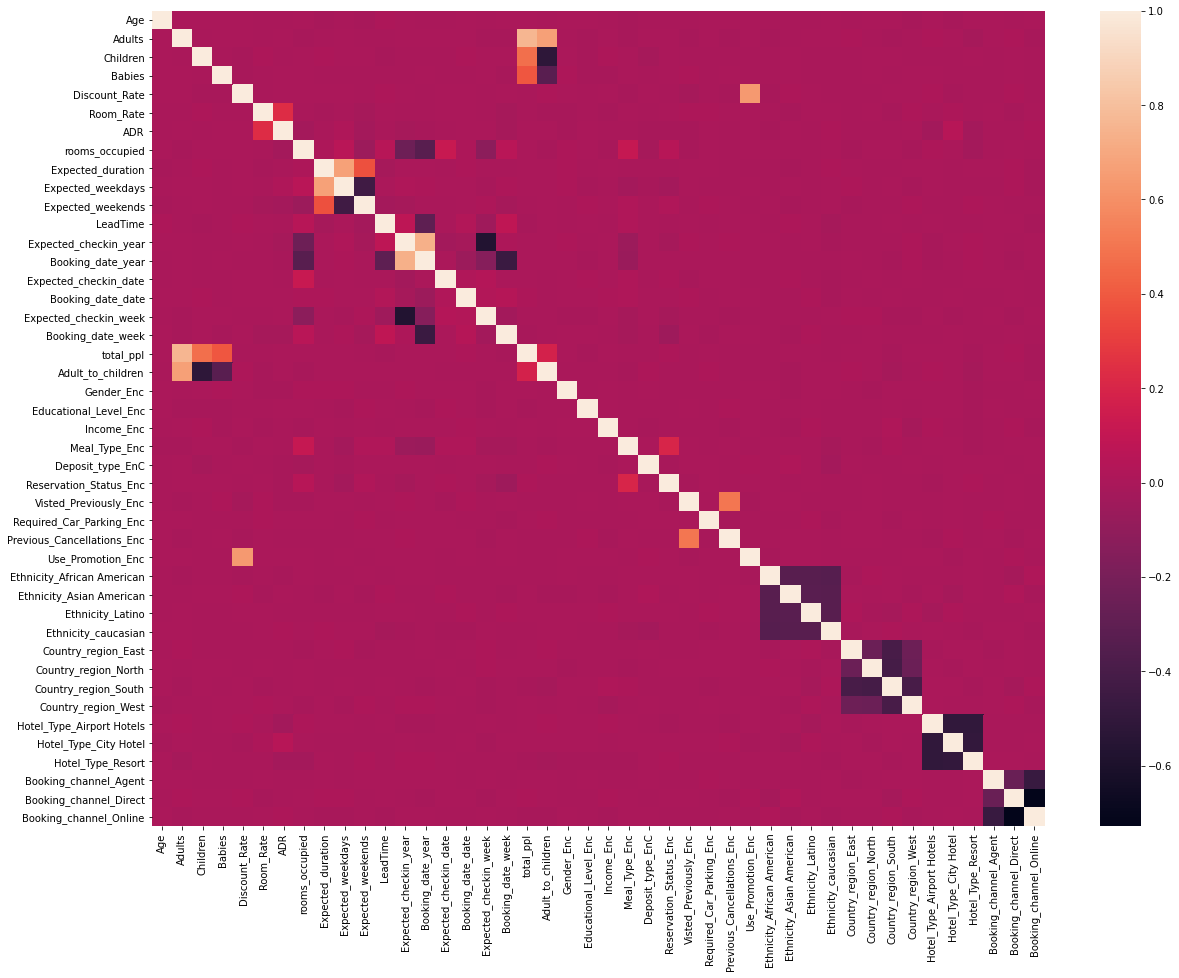

In [39]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,15))
ax = sns.heatmap(train_df.corr())

Model evaluation

In [44]:
train_X, train_y,train_df= preprocessor(train)
validation_X,validation_y,validation_df= preprocessor(validation,mode='val')
pca = decomposition.PCA(n_components=19)
pca.fit(train_X)
pca_train_X = pca.transform(train_X)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
base_models = [("DT_model", DecisionTreeClassifier( criterion='gini', splitter='random')),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=400)),
               ("XT_model",ExtraTreesClassifier()),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1,max_iter=250)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1)),
               ("MLP_model",MLPClassifier(random_state=42)),
               ("Knn_model",KNeighborsClassifier(n_neighbors=7)),
               ("LightGBM",LGBMClassifier()),
               ("CatBoost",CatBoostClassifier(n_estimators=400)),
               ("NB_model",GaussianNB()),
               ("LDA_model",LinearDiscriminantAnalysis())]

for name, model in (base_models):
  scores = cross_val_score(model, pca_train_X, train_y, scoring='f1_macro', cv=cv, n_jobs=-1)
  print(f"{name} F1 Score: {round(np.mean(scores),4), round(np.std(scores),4)}")

DT_model F1 Score: (0.3472, 0.0066)
RF_model F1 Score: (0.292, 0.0011)
XT_model F1 Score: (0.2981, 0.0026)
LR_model F1 Score: (0.2905, 0.0)
XGB_model F1 Score: (0.2907, 0.0003)
MLP_model F1 Score: (0.3082, 0.0051)
Knn_model F1 Score: (0.3094, 0.0032)
LightGBM F1 Score: (0.2915, 0.0015)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CatBoost F1 Score: (0.3004, 0.0017)
NB_model F1 Score: (0.2905, 0.0)
LDA_model F1 Score: (0.2905, 0.0)


In [46]:
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix,confusion_matrix,homogeneity_completeness_v_measure,accuracy_score,adjusted_rand_score
from sklearn import decomposition
train_X, train_y,train_df= preprocessor(train)
# train_X, train_y,train_df= balance(train_X, train_y,train_df)
validation_X,validation_y,validation_df= preprocessor(validation,mode='val')
pca = decomposition.PCA(n_components=19)
pca.fit(train_X)
pca_train_X = pca.transform(train_X)
pca_validation_X = pca.transform(validation_X)
model=DecisionTreeClassifier( criterion='gini',
                   splitter='random')
model.fit(pca_train_X,train_y)
pred=model.predict(pca_validation_X)
acc= accuracy_score(validation_y,pred)
fscore=f1_score(validation_y,pred,average="macro")
print(acc,fscore)
print(classification_report(validation_y,pred))

0.4990905783921426 0.35295971075055754
              precision    recall  f1-score   support

           1       0.60      0.72      0.66      1610
           2       0.29      0.23      0.25       741
           3       0.19      0.12      0.15       398

    accuracy                           0.50      2749
   macro avg       0.36      0.36      0.35      2749
weighted avg       0.46      0.50      0.47      2749



In [47]:
test_X = preprocessor(test,mode='test')
pca_test_X = pca.transform(test_X)
y_pred = model.predict(pca_test_X)
submission = pd.DataFrame({'Reservation-id':test['Reservation-id'],'Reservation_status':y_pred})
submission.head(5)
submission.to_csv('./submission-5.csv',index=False)